In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skopt import BayesSearchCV

from xgboost import XGBClassifier

%matplotlib inline

In [232]:
class BayesSearchCV(BayesSearchCV):
    def _run_search(self, x): raise BaseException('Use newer skopt')

In [160]:
df = pd.read_csv('./data/all_categoricals.csv', index_col = 0)

In [255]:
!ls data

aac_intakes.csv          df_cat.csv               hr_name.csv
aac_intakes_outcomes.csv df_dog.csv               master_df.csv
aac_outcomes.csv         df_mod.csv               master_df_1128.csv
all_categoricals.csv     engineered.csv           master_df_1129.csv
concat_backup.csv        hour_ids.csv


In [256]:
df_name_hour = pd.read_csv('./data/hr_name.csv', index_col=0)

In [260]:
df = df_name_hour.drop(labels=['name'], axis=1).merge(df, on='animal_id')

In [272]:
df.isna().sum()

animal_id                    0
name_freq                    0
hour                         0
age                          0
dow                          0
gender                       0
mix                          0
name                         0
animal_type_Cat              0
animal_type_Dog              0
fixed_status_fixed           0
fixed_status_intact          0
group_Herding                0
group_Hound                  0
group_Non-Sporting           0
group_Sporting               0
group_Terrier                0
group_Toy                    0
group_Working                0
group_long hair              0
group_short hair             0
intake_condition_Aged        0
intake_condition_Feral       0
intake_condition_Injured     0
intake_condition_Normal      0
intake_condition_Nursing     0
intake_condition_Other       0
intake_condition_Pregnant    0
intake_condition_Sick        0
intake_season_fall           0
                            ..
simple_color_Sable           0
simple_c

In [265]:
df_model.shape

(63143, 68)

In [162]:
df = df[df['outcome_type'] != 'Rto-Adopt']
df = df[df['outcome_type'] != 'Missing']
df = df[df['outcome_type'] != 'Disposal']

In [266]:
# We don't need animal id for modeling
df_model = df.iloc[:, 1:]

In [267]:
df_model = df_model[~df_model.duplicated()]

In [268]:
df['outcome_type'].value_counts()

Adoption           33455
Transfer           22946
Return to Owner    14938
Euthanasia          2873
Died                 540
Name: outcome_type, dtype: int64

In [269]:
df_model['outcome_type'].value_counts()

Adoption           32562
Transfer           20458
Return to Owner    14518
Euthanasia          2847
Died                 532
Name: outcome_type, dtype: int64

Drop the days in shelter feature for now. This will be used later in regression analysis if needed.

In [273]:
df_model = df_model.drop(labels=['days_in_shelter'], axis=1)

In [274]:
df_model.head()

,name_freq,hour,age,dow,gender,mix,name,animal_type_Cat,animal_type_Dog,fixed_status_fixed,...,hour_in_22,hour_in_23,hour_in_3,hour_in_4,hour_in_5,hour_in_6,hour_in_7,hour_in_8,hour_in_9,outcome_type
0,52,12,2920,6,1,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,Return to Owner
1,1,18,330,3,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,Return to Owner
2,0,7,28,0,1,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,Transfer
3,22,10,1460,6,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,Return to Owner
4,32,12,730,5,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,Return to Owner


In [275]:
df_model.columns.values

array(['name_freq', 'hour', 'age', 'dow', 'gender', 'mix', 'name',
       'animal_type_Cat', 'animal_type_Dog', 'fixed_status_fixed',
       'fixed_status_intact', 'group_Herding', 'group_Hound',
       'group_Non-Sporting', 'group_Sporting', 'group_Terrier',
       'group_Toy', 'group_Working', 'group_long hair',
       'group_short hair', 'intake_condition_Aged',
       'intake_condition_Feral', 'intake_condition_Injured',
       'intake_condition_Normal', 'intake_condition_Nursing',
       'intake_condition_Other', 'intake_condition_Pregnant',
       'intake_condition_Sick', 'intake_season_fall',
       'intake_season_spring', 'intake_season_summer',
       'intake_season_winter', 'intake_type_Euthanasia Request',
       'intake_type_Owner Surrender', 'intake_type_Public Assist',
       'intake_type_Stray', 'simple_color_Black', 'simple_color_Blue',
       'simple_color_Brown', 'simple_color_Gray', 'simple_color_Red',
       'simple_color_Sable', 'simple_color_Tricolor',
       'sim

In [278]:
df_model = df_model.drop(labels=['hour_in_0',
       'hour_in_1', 'hour_in_10', 'hour_in_11', 'hour_in_12',
       'hour_in_13', 'hour_in_14', 'hour_in_15', 'hour_in_16',
       'hour_in_17', 'hour_in_18', 'hour_in_19', 'hour_in_2',
       'hour_in_20', 'hour_in_21', 'hour_in_22', 'hour_in_23',
       'hour_in_3', 'hour_in_4', 'hour_in_5', 'hour_in_6', 
       'hour_in_7', 'hour_in_8', 'hour_in_9'], axis=1)

In [279]:
X = df_model.iloc[:, :-1]

In [215]:
X = pd.concat([X, pd.get_dummies(df_model['dow'].astype(str))], axis=1)

In [280]:
y = df_model.iloc[:, -1]

In [281]:
le = LabelEncoder()
le.fit(y)

LabelEncoder()

In [282]:
le.classes_

array(['Adoption', 'Died', 'Euthanasia', 'Return to Owner', 'Transfer'],
      dtype=object)

In [283]:
y = le.transform(y)

In [285]:
X.head()

,name_freq,hour,age,dow,gender,mix,name,animal_type_Cat,animal_type_Dog,fixed_status_fixed,...,intake_type_Stray,simple_color_Black,simple_color_Blue,simple_color_Brown,simple_color_Gray,simple_color_Red,simple_color_Sable,simple_color_Tricolor,simple_color_White,simple_color_Yellow
0,52,12,2920,6,1,0,1,0,1,1,...,1,0,0,0,0,0,0,0,1,0
1,1,18,330,3,0,1,1,0,1,0,...,1,0,0,0,0,0,1,0,0,0
2,0,7,28,0,1,1,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
3,22,10,1460,6,0,1,1,0,1,1,...,1,0,0,0,0,0,0,0,0,1
4,32,12,730,5,0,1,1,0,1,1,...,0,0,0,1,0,0,0,0,0,0


In [286]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 2325)

In [287]:
rf_cv = RandomForestClassifier(n_estimators = 800, max_features='sqrt', max_leaf_nodes=50,
                               max_depth = 100)

rf_cv.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='sqrt', max_leaf_nodes=50,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

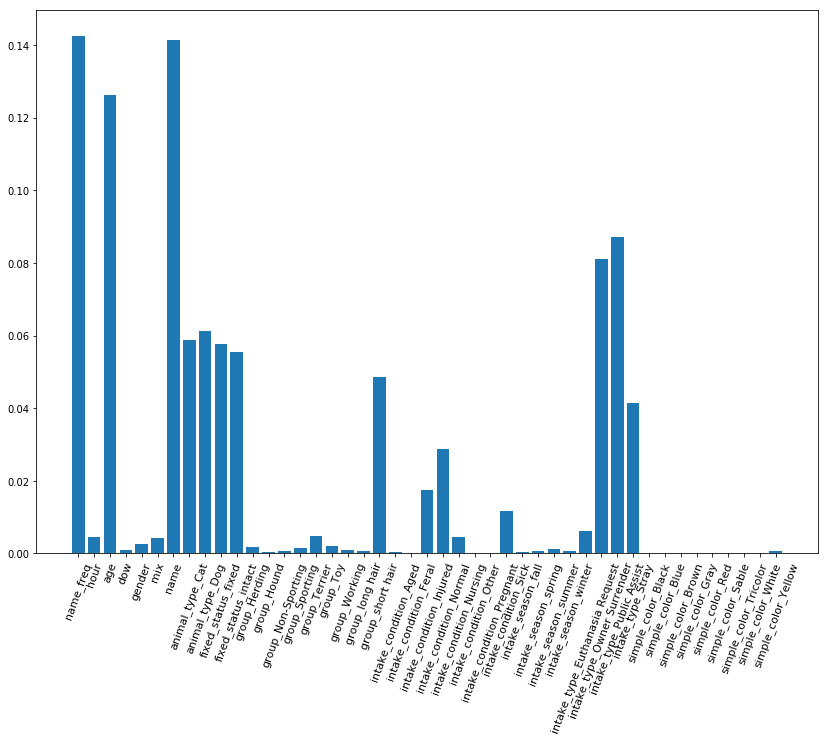

In [288]:
plt.figure(figsize=(14, 10))
plt.bar(X_train.columns.values, rf_cv.feature_importances_)
plt.xticks(rotation=70, size=11);

In [ ]:
rfc = RandomForestClassifier()

tuning_params_rf = {'n_estimators': [300, 800], 'max_features': ['sqrt'], 'max_leaf_nodes': [50, 100],
                    'max_depth': [50, 200]}

bs = BayesSearchCV(rfc, tuning_params_rf, n_jobs=-1, n_iter = 20, scoring='f1_micro', cv=3)

bs.fit(X_train, y_train)

In [ ]:
bs.best_score_

## XGBoost hyperparameter tuning

In [242]:
xg = XGBClassifier(n_jobs = -1)

tuning_params = {'max_depth': [5, 90], 'learning_rate': [0, 1], 'objective': ['multi:softprob'],
                 'min_child_weight': [1, 3, 5]}

bs = BayesSearchCV(xg, tuning_params, cv=3, verbose=True, scoring = 'neg_log_loss', n_jobs=-1, n_iter = 10)

bs.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.1min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.5min finished


BayesSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_iter=10, n_jobs=-1, n_points=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
       refit=True, return_train_score=False, scoring='neg_log_loss',
       search_spaces={'max_depth': [5, 90], 'learning_rate': [0, 1], 'objective': ['multi:softprob'], 'min_child_weight': [1, 3, 5]},
       verbose=True)

In [243]:
bs.best_params_

{'learning_rate': 1,
 'max_depth': 9,
 'min_child_weight': 3,
 'objective': 'multi:softprob'}

In [244]:
bs.best_score_

-1.163886223682593

In [228]:
pipe = make_pipeline(StandardScaler(), XGBClassifier(learning_rate=0.1, max_depth=7, min_child_weight=3))

In [229]:
scores = cross_val_score(pipe, cv=3, n_jobs = -1, scoring='f1_micro', X=X_train, y=y_train)

In [230]:
scores

array([0.64014696, 0.6450019 , 0.64375317])